In [1]:
import pandas as pd
import numpy as np
# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import dexplot as dxp

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score 
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
# import graphviz
# Scaling with Minmax-scaler
from sklearn.preprocessing import MinMaxScaler

# from ydata_profiling import ProfileReport

# import custom functions
from custom_functions import our_metrics

pd.set_option('display.max_rows', 10)

In [2]:
# plot settings

# custom color palette: 
#colors = ['#365b6d', '#41c1ba', '#289dd2', '#6c9286', '#f2f1ec', '#fa9939']
#365b6d - dark blue
#41c1ba - turquoise
#289dd2 - medium blue
#6c9286 - muddy green
#fa9939 - orange 
#f2f1ec - off-white

# Set your custom color palette

#sns.set(style="white", rc={"axes.facecolor": "#f2f1ec", "figure.facecolor": "#f2f1ec"}) 
#custom_palette = sns.set_palette(sns.color_palette(colors))
#sns.set_palette(sns.color_palette(colors))

# for multiple plots
# sns.despine(left=True, bottom=True)

In [69]:
# set seaborn options globally
colors = ['#365b6d', '#41c1ba', '#289dd2', '#6c9286', '#f2f1ec', '#fa9939']
custom_palette = sns.set_palette(sns.color_palette(colors))
custom_params = {"axes.facecolor": "#f2f1ec", 
"figure.facecolor": "#f2f1ec",
'figure.titleweight': 'bold',
'figure.titlesize': 28,#'large',
'grid.alpha': 1.0,
'font.size': 16.0,
'font.weight': 'bold',
'axes.labelsize': 16,
'axes.labelcolor': '#365b6d',
'axes.titlepad': 10.0,
'axes.titlesize': 'large',
'xtick.labelsize': 16,
'xtick.color': '#365b6d',
'xtick.bottom': True,
'ytick.labelsize': 16,
'ytick.color': '#365b6d',
'ytick.left': True,
'text.color' : '#365b6d',
#'legend.labelcolor': '#365b6d',
'legend.title_fontsize': 12.0,
'legend.frameon': False,
'axes.linewidth': 3,#0.8,
'axes.spines.left': True,
'axes.spines.bottom': True,
'axes.spines.right': True,
'axes.spines.top': True,
'axes.edgecolor': '#365b6d',
'axes.labelweight': 'bold',
'axes.titleweight': 'bold',
'patch.edgecolor': '#f2f1ec'
}
sns.set_theme(style="white", palette=colors, rc=custom_params)

# Preliminaries from kappa_combined_clean.ipynb

In [55]:
# import features for tree-based models
X_train_comb = pd.read_csv('../data/petfinder-adoption-prediction/train/X_train_minmax_scaled_processed.csv')
X_test_comb =pd.read_csv('../data/petfinder-adoption-prediction/train/X_test_minmax_scaled_processed.csv')

# import target
y_train_comb = pd.read_csv('../data/petfinder-adoption-prediction/train/y_train.csv')
y_test_comb = pd.read_csv('../data/petfinder-adoption-prediction/train/y_test.csv')

gbc = GradientBoostingClassifier(n_estimators=200,subsample=1, max_leaf_nodes=31, max_features='log2', max_depth=5, loss = 'log_loss', learning_rate=0.025, random_state=42)
gbc.fit(X_train_comb,y_train_comb)
# Performance on test
y_pred = gbc.predict(X_test_comb)
#our_metrics(y_test_comb,y_pred)
# Performance on train
y_pred_tr = gbc.predict(X_train_comb)
#our_metrics(y_train_comb,y_pred_tr)

/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Preliminaries for Baseline Model

In [56]:
df_processed = pd.read_csv('../data/petfinder-adoption-prediction/train/df_processed.csv')

X_baseline = df_processed[["age_bin", "photoamt_11"]]
y = df_processed["adoptionspeed"]
X_train_bl, X_test_bl, y_train_bl, y_test_bl = train_test_split(X_baseline, y, random_state=42, stratify=y)
baseline = DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 15)
baseline.fit(X_train_bl, y_train_bl)

y_pred_bl = baseline.predict(X_test_bl)
#our_metrics(y_test_bl, y_pred_bl, normalize=True)

In [57]:
# confusion matrix of best model
cm = confusion_matrix(y_test_comb, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# confusion model of baseline model
cm_bl = confusion_matrix(y_test_bl, y_pred_bl)
cm_bl_norm = cm_bl.astype('float') / cm_bl.sum(axis=1)[:, np.newaxis]


In [58]:
# get diagonal values
perc = cm_norm.diagonal()
perc_bl = cm_bl_norm.diagonal()

In [59]:
df_bl = pd.DataFrame(columns=[ 'accuracy'], data=np.transpose([ perc_bl]))
df_bl['adoptionspeed']= [1,2,3,4]
df_bl['model'] = 'baseline'
df_bl

,accuracy,adoptionspeed,model
0,0.375180,1,baseline
1,0.228824,2,baseline
2,0.130094,3,baseline
3,0.668831,4,baseline


In [60]:
df_best = pd.DataFrame(columns=[ 'accuracy'], data=np.transpose([ perc]))
df_best['adoptionspeed']= [1,2,3,4]
df_best['model'] = 'best_model'
df_best

,accuracy,adoptionspeed,model
0,0.388167,1,best_model
1,0.391909,2,best_model
2,0.153605,3,best_model
3,0.659740,4,best_model


In [61]:
df = pd.concat([df_bl, df_best])
df

,accuracy,adoptionspeed,model
0,0.375180,1,baseline
1,0.228824,2,baseline
2,0.130094,3,baseline
3,0.668831,4,baseline
0,0.388167,1,best_model
1,0.391909,2,best_model
2,0.153605,3,best_model
3,0.659740,4,best_model


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, 0 to 3
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   accuracy       8 non-null      float64
 1   adoptionspeed  8 non-null      int64  
 2   model          8 non-null      object 
dtypes: float64(1), int64(1), object(1)
memory usage: 256.0+ bytes


In [63]:
# get accuracy score of best model for reference line
acc = accuracy_score(y_test_comb, y_pred)
acc_bl = accuracy_score(y_test_comb, y_pred_bl)
k = cohen_kappa_score(y_test_comb, y_pred, weights='quadratic')
k_bl = cohen_kappa_score(y_test_comb, y_pred_bl, weights='quadratic')

In [64]:
df_scores = pd.DataFrame(columns=['model','score_name'], data=np.transpose([['Baseline']*2 + ['Best Model']*2, ['accuracy', 'kappa_score']*2 ]))
df_scores['score'] = [acc_bl, k_bl, acc, k]
df_scores

,model,score_name,score
0,Baseline,accuracy,0.359267
1,Baseline,kappa_score,0.221915
2,Best Model,accuracy,0.409751
3,Best Model,kappa_score,0.354709


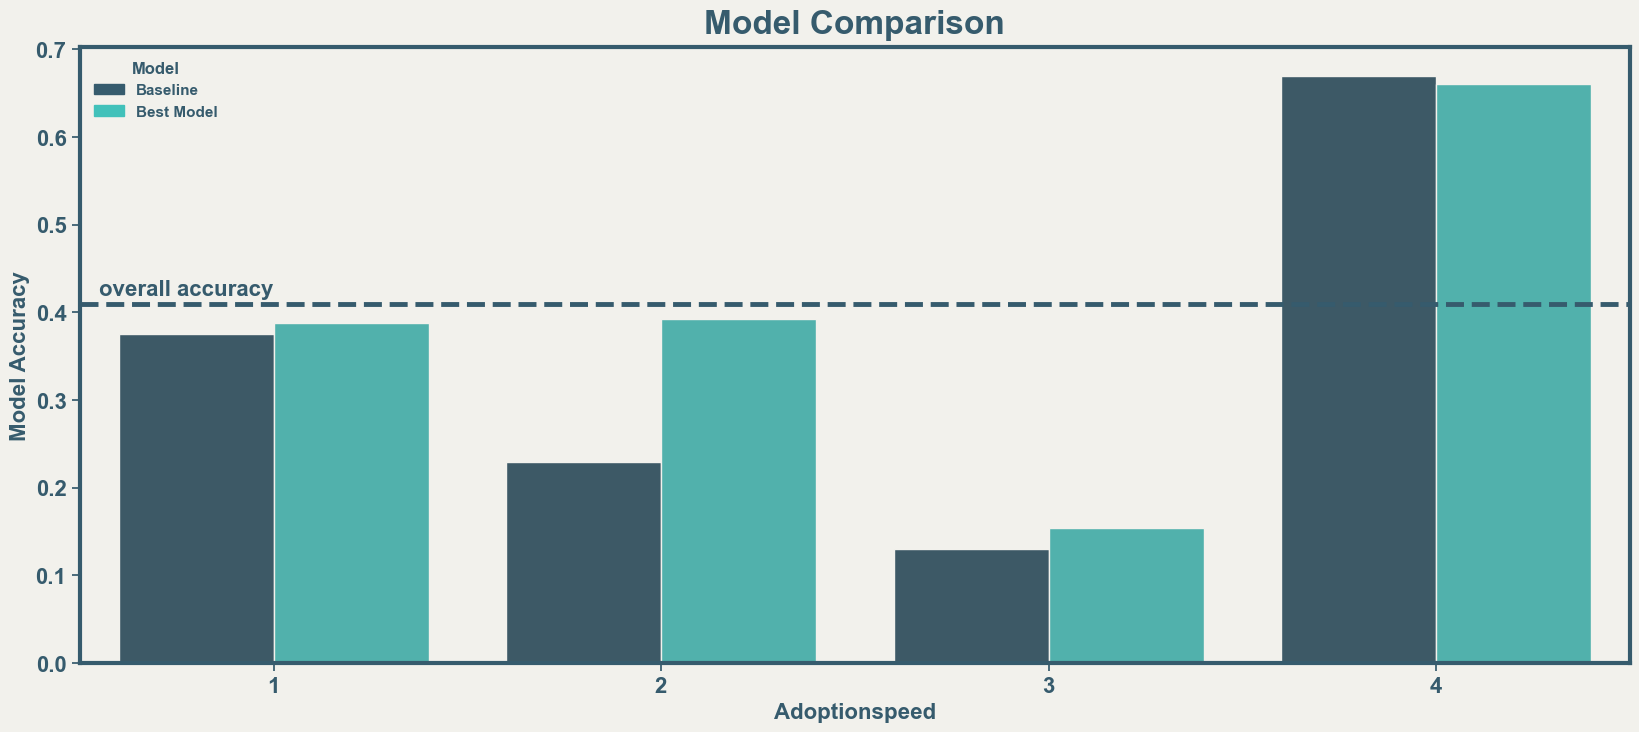

In [70]:
bbox = dict(boxstyle="round", fc='#41c1ba')#fc="0.8") box for annotations
fig = plt.figure(figsize=(20,8))
mod_plot = sns.barplot(
    data=df, 
    x='adoptionspeed', 
    y = 'accuracy',
    hue='model', 
    # palette=['#365b6d', '#41c1ba', '#289dd2', '#6c9286'], 
    # multiple='dodge', 
    # alpha=1,
    # shrink=3
    )
#h,l=mod_plot.get_legend_handles_labels()
#legend = plt.legend(title='Model Comparison')#,labels = ['Best Model','Baseline'])
legend_labels = ['Baseline','Best Model']
legend_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(['#365b6d', '#41c1ba'], legend_labels)]
plt.legend(handles=legend_handles, title='Model')#, title_fontsize=14, bbox_to_anchor=(0.65, 0.90), loc='upper left')


plt.xlabel('Adoptionspeed')
plt.ylabel('Model Accuracy')
plt.title('Model Comparison', fontsize=24)
# plt.xticks(ticks=np.linspace(0,18,10))
# # add vertical line
mod_plot.axhline(y=acc, linewidth=3.5, linestyle='dashed')
# Annotate hline
mod_plot.text(-0.45, acc + 0.01, 'overall accuracy')
# plt.annotate("'Not Adopted' most frequent for up to 3 photos", xy=(3.7, 950), bbox=bbox, fontsize=20)
# plt.annotate("'Fast Adoption Speeds' most frequent for more than 3 photos", xy=(3.7, 800), bbox=bbox, fontsize=20)

# #restrict x axis
# plt.xlim([-0.5, 16.5])
# safe figure as...
#plt.savefig('../images/presentation/photoamt_with_line.jpg')
plt.show();

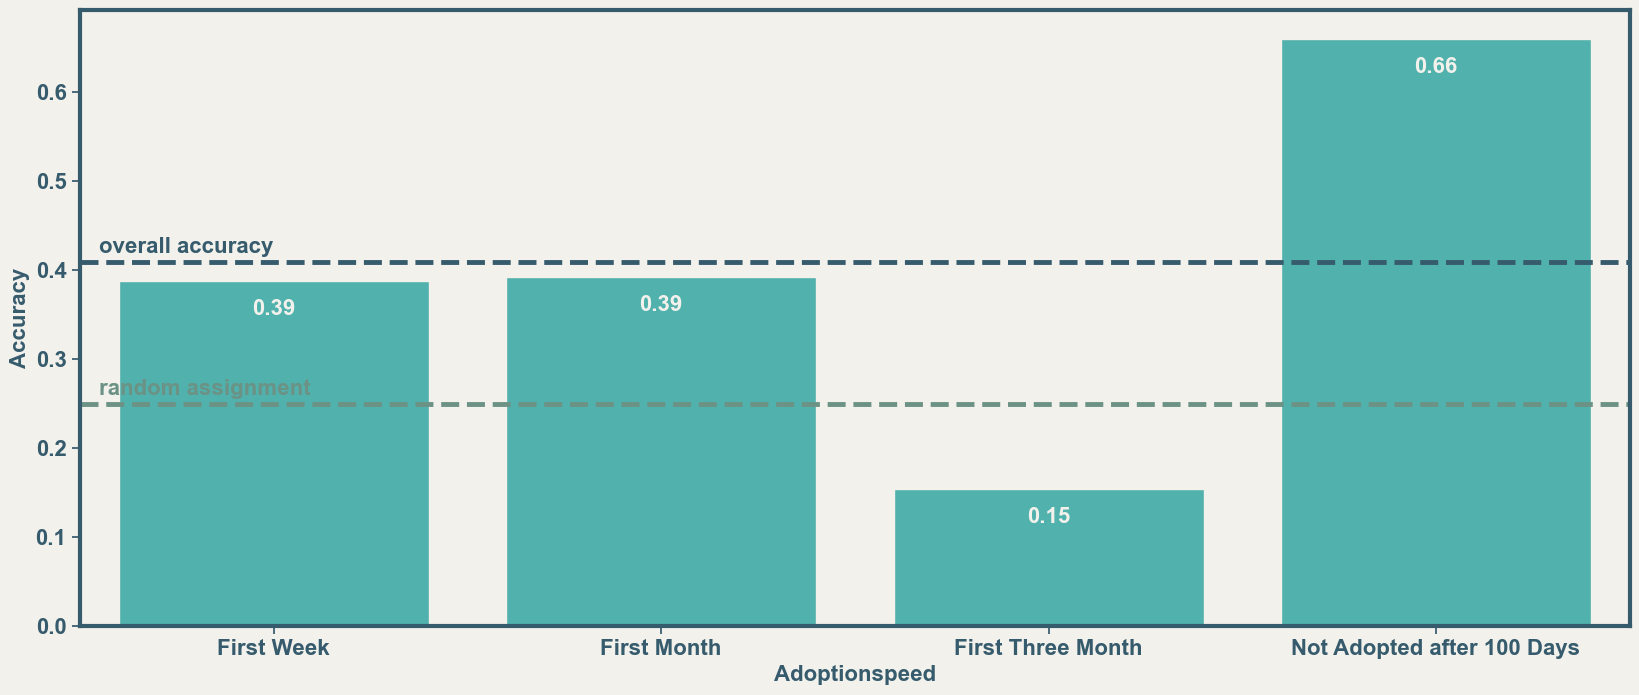

In [95]:
#bbox = dict(boxstyle="round", fc='#41c1ba')#fc="0.8") box for annotations
fig = plt.figure(figsize=(20,8))
mod_plot = sns.barplot(
    data=df.query('model=="best_model"'), 
    x='adoptionspeed', 
    y = 'accuracy',
    #hue='model', 
    # palette=['#365b6d', '#41c1ba', '#289dd2', '#6c9286'], 
    # multiple='dodge', 
    # alpha=1,
    color='#41c1ba'
    )
#h,l=mod_plot.get_legend_handles_labels()
#legend = plt.legend(title='Model Comparison')#,labels = ['Best Model','Baseline'])

plt.xlabel('Adoptionspeed')
plt.ylabel('Accuracy')
#plt.title('Model Performance on Target Groups')#, fontsize=24)
# plt.xticks(ticks=np.linspace(0,18,10))
# # add horizontal line
mod_plot.axhline(y=acc, linewidth=3.5, linestyle='dashed')
# Annotate hline
mod_plot.text(-0.45, acc + 0.01, 'overall accuracy')

mod_plot.axhline(y=0.25, linewidth=3.5, linestyle='dashed', color='#6c9286')
# Annotate hline
mod_plot.text(-0.45, 0.25 + 0.01, 'random assignment', color='#6c9286')
#365b6d - dark blue
#41c1ba - turquoise
#289dd2 - medium blue
#6c9286 - muddy green
#fa9939 - orange 
#f2f1ec - off-white
for g in mod_plot.patches:
    mod_plot.annotate(format(g.get_height(), '.2f'),
                   (g.get_x() + g.get_width() / 2., g.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, -20),
                   textcoords = 'offset points',
                   color = '#f2f1ec')

# plt.annotate("'Not Adopted' most frequent for up to 3 photos", xy=(3.7, 950), bbox=bbox, fontsize=20)
# plt.annotate("'Fast Adoption Speeds' most frequent for more than 3 photos", xy=(3.7, 800), bbox=bbox, fontsize=20)
mod_plot.set_xticklabels(['First Week','First Month','First Three Month','Not Adopted after 100 Days'])

# #restrict x axis
# plt.xlim([-0.5, 16.5])
# safe figure as...
#plt.savefig('../images/presentation/photoamt_with_line.jpg')
plt.show();

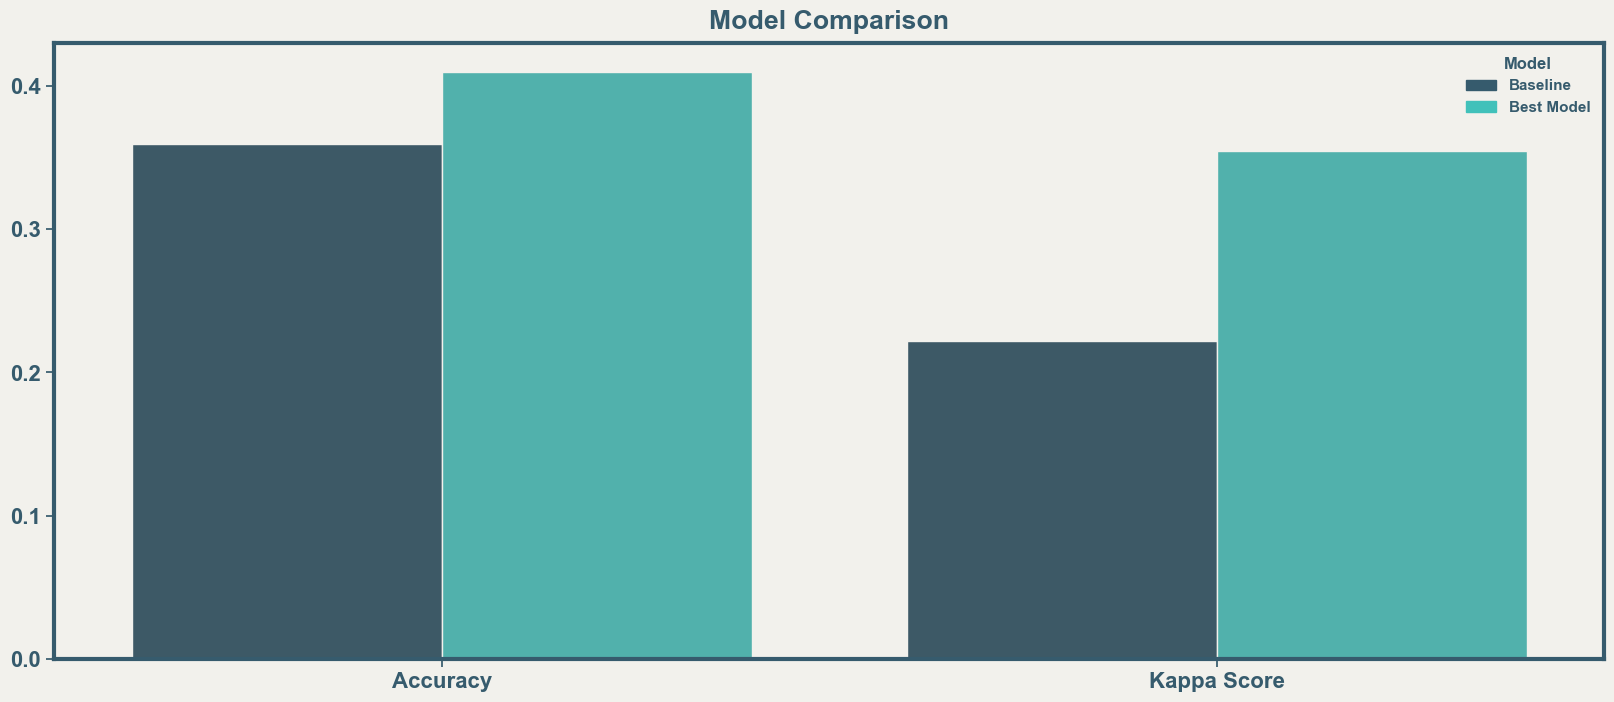

In [73]:
fig = plt.figure(figsize=(20,8))
scores_plot = sns.barplot(
    data=df_scores, 
    x='score_name', 
    y = 'score',
    hue='model', 
    # palette=['#365b6d', '#41c1ba', '#289dd2', '#6c9286'], 
    # multiple='dodge', 
    # alpha=1,
    )

legend_labels = ['Baseline','Best Model']
legend_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(['#365b6d', '#41c1ba'], legend_labels)]
plt.legend(handles=legend_handles, title='Model')#, title_fontsize=14, bbox_to_anchor=(0.65, 0.90), loc='upper left')

plt.xlabel('')
plt.ylabel('')
plt.yticks(ticks=np.linspace(0,0.4,5))
scores_plot.set_xticklabels(['Accuracy', 'Kappa Score'])
plt.title('Model Comparison')#, fontsize=24)

# safe figure as...
#plt.savefig('../images/presentation/scores_plot.jpg')
plt.show();

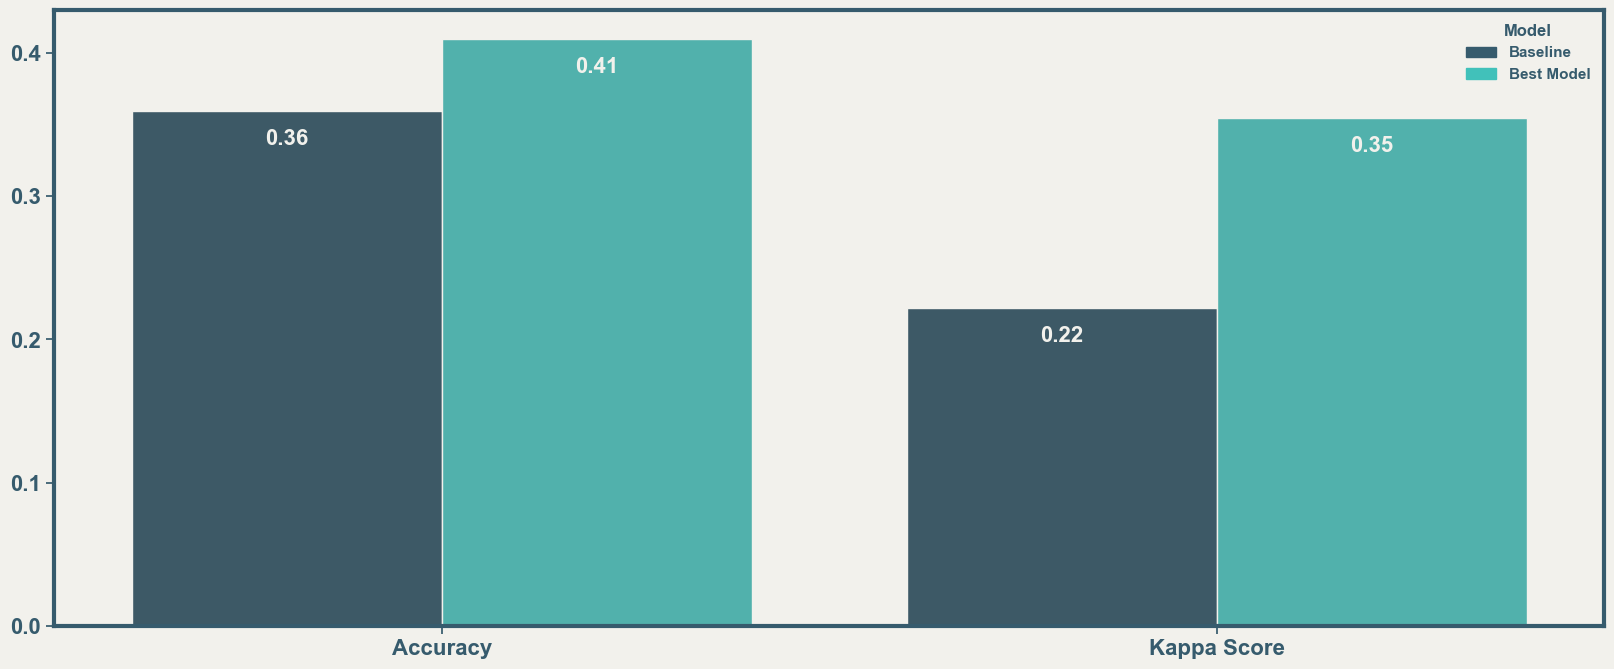

In [88]:
fig = plt.figure(figsize=(20,8))
scores_plot = sns.barplot(
    data=df_scores, 
    x='score_name', 
    y = 'score',
    hue='model', 
    # palette=['#365b6d', '#41c1ba', '#289dd2', '#6c9286'], 
    # multiple='dodge', 
    # alpha=1,
    )

legend_labels = ['Baseline','Best Model']
legend_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(['#365b6d', '#41c1ba'], legend_labels)]
plt.legend(handles=legend_handles, title='Model')#, title_fontsize=14, bbox_to_anchor=(0.65, 0.90), loc='upper left')

plt.xlabel('')
plt.ylabel('')
scores_plot.set_xticklabels(['Accuracy', 'Kappa Score'])
#plt.title('Model Comparison')#, fontsize=24)

for g in scores_plot.patches:
    scores_plot.annotate(format(g.get_height(), '.2f'),
                   (g.get_x() + g.get_width() / 2., g.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, -20),
                   textcoords = 'offset points',
                   color = '#f2f1ec')
plt.yticks(ticks=np.linspace(0,0.4,5))
# safe figure as...
#plt.savefig('../images/presentation/scores_plot.jpg')
plt.show();